In [3]:
import os
import re
import math
import time
import torch

import librosa
import librosa.display

import functools
import torchaudio
import torchvision
import torch.optim


import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from functools import partial
import torch.nn.functional as F
from torch.utils.data import DataLoader

import IPython.display as ipd

from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from torch import nn, einsum
from inspect import isfunction



import torchaudio.transforms as T

import IPython.display as ipd
import sentencepiece as spm
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence


import torch.utils.data
from librosa.util import normalize
from scipy.io.wavfile import read
from librosa.filters import mel as librosa_mel_fn

import pickle
import soundfile as sf
from scipy import signal
from scipy.signal import get_window
from librosa.filters import mel

MAX_WAV_VALUE = 32768.0




In [10]:
is_cuda = torch.cuda.is_available()

device = torch.device('cuda:0' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda:0


In [6]:
cd ../

/data/code/kmkim


In [11]:
from hifi_gan import Generator as hifigan_vocoder
from omegaconf import OmegaConf

path_config = 'hifi_gan.json'
path_ckpt = 'g_02500000'

hifigan_config = OmegaConf.load(path_config)
vocoder = hifigan_vocoder(hifigan_config)

state_dict_g = torch.load(path_ckpt)
vocoder = vocoder.to(device)
vocoder.load_state_dict(state_dict_g['generator'])
vocoder.eval()

Generator(
  (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (ups): ModuleList(
    (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
    (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
  )
  (resblocks): ModuleList(
    (0): ResBlock1(
      (convs1): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
      )
      (convs2): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride

In [12]:
def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)


def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C


def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)
    # return torch.clamp(x, min=clip_val) * C


def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output


sr = 22050
n_fft = 1024
win_length = n_fft
hop_length = 256

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft=n_fft, num_mels=80, sampling_rate= sr, hop_size=hop_length, win_size=win_length, fmin=0, fmax=8000, center=False):
    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax) + '_' + str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)
    
    #print(y.shape) # 45237, 1 (1024-256)/2, (1024-256)/2
    y = torch.nn.functional.pad(y.unsqueeze(0), ((int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2))),
                                mode='reflect')
    y = y.squeeze(1)
    
    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex = False) # return_complex =False

    spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9)) #???

    spec = torch.matmul(mel_basis[str(fmax) + '_' + str(y.device)], spec)
        
    spec = librosa.power_to_db(spec, ref=np.max, top_db = num_mels) ## dB 단위로 변형 numpy로 결과가 나옴
    

    spec = (spec / 80.0) + 1

    
    return torch.from_numpy(spec.astype("float32")) ## numpy를 torch로

In [13]:
def inference_to_audio(x, sr = 22050, n_mels = 80):
    
    inference_ = (x.cpu() - 1) * 80.0

    S = librosa.db_to_power(inference_)

    zxc = spectral_normalize_torch(S.squeeze()) ## 나온 power 정규화 필수
    
    conv_wav = vocoder(zxc.to(device)) 
    
    conv_wav = conv_wav.squeeze().detach().cpu().numpy()
    
    print(librosa.display.waveshow(conv_wav))
    
    return conv_wav

In [14]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

In [31]:
  #original
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


In [34]:


class SinusoidalPositionEmbeddings(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1) ## [N, N * 2]

In [16]:
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

In [17]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [18]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [19]:
def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

In [20]:


class Unet_(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: init_dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = init_dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(init_dim),
            nn.Linear(init_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(init_dim * 2, init_dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(init_dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

# Classifier (Unet_Encoder)

In [21]:

class UnetEncoder(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim= None,
        dim_mults=(1, 2, 4),
        channels=1,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: init_dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = init_dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(init_dim),
            nn.Linear(init_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        self.out_dim = default(out_dim, channels)
        
        self.out = nn.Sequential(
        nn.Linear(256*10*7, 2048),
        nn.ReLU(),
        nn.Linear(2048, self.out_dim),
        )
        
#         self.out = nn.Sequential(
#                 normalization(ch),
#                 nn.SiLU(),
#                 AttentionPool2d(
#                 (image_size // ds), ch, num_head_channels, out_channels
#                 ),
#             )
        

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)
        x = torch.nn.Flatten()(x)
        
        x = self.out(x)
        return x

In [22]:
class AudioDataset(Dataset):
    def __init__(self, path, feature_transform=None, label_transform=None,):
        self.path = path
        self.file_list = []
        self.label_list = []
        self.feature_transform = feature_transform
        self.label_transform = label_transform
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] != "txt":
                    self.file_list.append(os.path.join(dirname, filename))
                    self.label_list.append(int(filename[0]))
        
        total_len = len(self.file_list)
        
                    
    def __getitem__(self, idx):
        try:
            audio, sr = torchaudio.load(self.file_list[idx])
            label = self.label_list[idx]
            return audio, sr, label
        except:
            audio, sr = torchaudio.load(self.file_list[0])
            label = self.label_list[idx]
            return audio, sr, label
    
    def __len__(self):
        return len(self.file_list)

In [23]:
def collate_fn(batch):
    
    src_speech = [] 
    src_label = []
    
    for samples, sr, label in batch:                    
                
        resample_audio = torchaudio.functional.resample(samples, orig_freq=sr, new_freq=22050) ## [1,153600]
        
        mel_spec = mel_spectrogram(resample_audio[0][:14512])
                
        src_speech.append(mel_spec.squeeze().permute(1,0)) 
        
        src_label.append(label)
    
    speech_batch = pad_sequence(src_speech, padding_value = 0.0, batch_first = True) # batch, Frame, mel
    
    speech_batch =speech_batch.permute(0,2,1)
    
    return speech_batch.unsqueeze(1), torch.tensor(src_label) ## batch, 1, mel, time

In [24]:
import torchvision.transforms as T

batch_size = 32

train_ds = AudioDataset('./diffusion_speech_enhancement/guided_speech_diffusion/data/', label_transform=T.ToTensor())

data_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    collate_fn = collate_fn,
    num_workers = 8,
    shuffle=True,
    pin_memory = True,
    drop_last = True
)


In [32]:

model = Unet_(
    dim=56,
    channels=1,
    init_dim = 64,
    dim_mults=(1, 2, 2, 4,),
    resnet_block_groups = 32,
)

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [26]:
classifier = UnetEncoder(
    dim=56,
    channels=1,
    init_dim = 64,
    out_dim = 10,
    dim_mults=(1, 2, 2, 4,),
    resnet_block_groups = 32,
)

classifier.to(device)

UnetEncoder(
  (init_conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(32, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(32, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (1): ResnetBlock

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

classifier_optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4)

def classifier_losses(denoise_model,marginal_prob_std, x_start, y, t):
    
    z = torch.randn_like(x_start)
    
    std = marginal_prob_std(t)
    
    perturbed_x = x_start + z * std[:, None, None, None]
    
    logits = denoise_model(perturbed_x, t)
    
    losses = criterion(logits, y)
    
    return losses

# Classifier Training

In [ ]:
from tqdm import tqdm
epoch_num = 300
before_loss = 999999.0
saved_epoch = 0
patient = 0
for epoch in range(epoch_num):
    
    total_loss = 0
    
    for step, (data, target) in enumerate(tqdm(data_loader)):
        data = data.to(device)
        target = target.to(device)
        classifier_optimizer.zero_grad()
        
        random_t = torch.rand(data.shape[0], device=data.device) * (1. - 1e-5) + 1e-5
        
        loss = classifier_losses(classifier,marginal_prob_std_fn, data, target, random_t)
        
        total_loss += loss
        
        loss.backward()
        classifier_optimizer.step()
        
    total_loss = total_loss / len(data_loader)
    print(f"epoch : {epoch} Loss : {total_loss} ")
    
    if before_loss > total_loss:
        saved_epoch = epoch
        print(f"before_loss = {before_loss:.4f}, loss = {total_loss:.4f}, saved_epoch = {saved_epoch}" )
        print('model_save')
        torch.save(classifier.state_dict(), 'diffusion_speech_enhancement/guided_speech_diffusion/SDE_Speech_enhancement_classifier_Fourier.pth')
        before_loss = total_loss
        patient = 0
    else:
        patient += 1
        if patient > 30:
            print("early stopping")
            break
        

In [ ]:
epochs = 300
before_loss = 999999.0
saved_epoch = 0

# save_and_sample_every = 10

for epoch in range(epochs):
    
    total_loss = 0

    for step, batch in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()

        batch_size = batch[0].shape[0]
        speech = batch[0].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch

        loss = loss_fn(model, speech, marginal_prob_std_fn)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        
    total_loss = total_loss / len(data_loader)
    print(f"epoch : {epoch} Loss : {total_loss} ")
    
    if before_loss > total_loss:
            saved_epoch = epoch
            print(f"before_loss = {before_loss:.4f}, loss = {total_loss:.4f}, saved_epoch = {saved_epoch}" )
            print('model_save')
            torch.save(model.state_dict(), 'diffusion_speech_enhancement/guided_speech_diffusion/SDE_enhancement.pth')
            before_loss = total_loss

In [33]:
ckpt = torch.load('diffusion_speech_enhancement/guided_speech_diffusion/SDE_enhancement.pth', map_location=device)
model.load_state_dict(ckpt)
model = model.to(device)

In [28]:
ckpt = torch.load('diffusion_speech_enhancement/guided_speech_diffusion/SDE_Speech_enhancement_classifier_Fourier.pth', map_location=device)
classifier.load_state_dict(ckpt)
classifier.to(device)

UnetEncoder(
  (init_conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(32, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(32, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (1): ResnetBlock

## Noisy data 생성

In [ ]:
## Korean Speech
inference_data = torchaudio.load('kss_data/kss/4/4_5630.wav')[0]
inference_resample_audio = torchaudio.functional.resample(inference_data, orig_freq=44100, new_freq=22050)
inference_mel= mel_spectrogram(inference_resample_audio[0][:-(256*4)]) ## [1,80,128] 



In [122]:
## VCTK data
inference_resample_audio = torchaudio.functional.resample(train_ds[1][0], orig_freq=48000, new_freq=22050)
inference_mel = mel_spectrogram(inference_resample_audio[0][:-(256*3)]) #[11025:32802+11025]

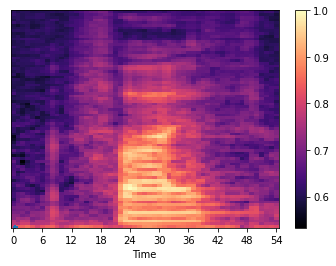

In [132]:
# 원본 Mel 과 음성 확인

fig, ax = plt.subplots()
img = librosa.display.specshow(inference_mel[0].numpy())
fig.colorbar(img, ax=ax)
a = inference_to_audio(inference_mel[0])
ipd.Audio(a, rate= 22050)


In [ ]:
inference_resample_audio = torchaudio.functional.resample(train_ds[1][0], orig_freq=48000, new_freq=22050)
inference_mel = mel_spectrogram(inference_resample_audio[0][:-(256*3)]) #[11025:32802+11025]


s , l = next(iter(data_loader))


In [126]:
s , l = next(iter(data_loader))


In [133]:
def SDE_noisy_data(x, marginal_prob_std, t, eps = 1e-5):
    t = torch.tensor([t]) * (1. - eps) + eps
    #random_t = torch.rand(x.shape[0], device= device) * (1. - eps) + eps
    z = torch.randn_like(x, device = device)
    std = marginal_prob_std(t)
    x = x.to(device)
    return x + z * std[:, None, None, None]
    

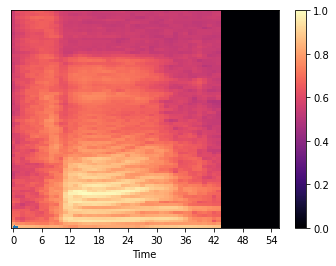

In [137]:

fig, ax = plt.subplots()
img = librosa.display.specshow(s[3].squeeze().numpy())
fig.colorbar(img, ax=ax)
a = inference_to_audio(s[3])
ipd.Audio(a, rate= 22050)

In [164]:
nosiy_data = SDE_noisy_data(s[3], marginal_prob_std_fn, 0.05)

/tmp/ipykernel_390/2894061068.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


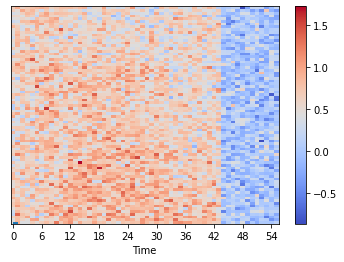

In [165]:
# 노이즈 첨가 Mel 과 음성 확인

#nosiy_data = q_sample(inference_mel, torch.tensor([30])) ## DDPM Noisy data generator
nosiy_data = nosiy_data.cpu() ## SDE
fig, ax = plt.subplots()
img = librosa.display.specshow(nosiy_data.squeeze().numpy())
fig.colorbar(img, ax=ax)
a = inference_to_audio(nosiy_data[0])
ipd.Audio(a, rate= 22050)

In [194]:
num_steps = 300
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps, 
                           device='cuda',
                           z = None,
                           classifier = None,
                           classes = None,
                           input_t = None,
                           eps=1e-5):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    if input_t is None:
        t = torch.ones(batch_size, device=device)
        time_steps = torch.linspace(1., eps, num_steps, device=device)
    else:
        t = torch.tensor([input_t], device=device)
        time_steps = torch.linspace(input_t, eps, num_steps, device=device)
    
    if z is None:
        init_x = torch.randn(batch_size, 1, 80, 56, device=device) * marginal_prob_std(t)[:, None, None, None]
    else:
        z = z.to(device)
        init_x = z
    
    shape = init_x.shape    
    
    
    
    
    step_size = time_steps[0] - time_steps[1]
    x = init_x 
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            
            if classifier is None:
                gradient = 0
            ##classifier gradient computation
            else:
                gradient = cond_fn(classifier, x, batch_time_step, classes)
                #gradient = gradient * 10.0
            
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * (score_model(x, batch_time_step) + gradient) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
    return mean_x

In [201]:
signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  300#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               classes = None,
               classifier = None,
               input_t = None,
               z= None,
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    
    if input_t is None:
        t = torch.ones(batch_size, device=device)
        time_steps = torch.linspace(1., eps, num_steps, device=device)
    else:
        t = torch.tensor([input_t], device=device)
        time_steps = torch.linspace(input_t, eps, num_steps, device=device)
    
    if z is None:
        init_x = torch.randn(batch_size, 1, 80, 56, device=device) * marginal_prob_std(t)[:, None, None, None]
    else:
        z = z.to(device)
        init_x = z
    
    shape = init_x.shape    
    
    if classifier is None:
        gradient = 0  

    #     t = torch.ones(batch_size, device=device)
    #     init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
    with torch.no_grad():
        for predictor_timstep in tqdm.notebook.tqdm(time_steps):
            
            batch_time_step = torch.ones(batch_size, device=device) * predictor_timstep
            
            for i in range(int(num_steps/10)):      
                # Corrector step (Langevin MCMC)
                classifier_gradient = cond_fn(classifier, x, batch_time_step, classes)
                grad = score_model(x, batch_time_step)
                grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
                noise_norm = np.sqrt(np.prod(x.shape[1:]))
                langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
                x = x + langevin_step_size * (grad+classifier_gradient) + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      
            
            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            classifier_gradient = cond_fn(classifier, x, batch_time_step, classes)
            x_mean = x + (g**2)[:, None, None, None] * ( score_model(x, batch_time_step) + classifier_gradient) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    # The last step does not include any noise
    return x_mean

In [95]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                num_steps = num_steps,
                atol=error_tolerance,
                rtol=error_tolerance, 
                device='cuda',
                classes = None,
                classifier = None,
                input_t = None,
                z=None,
                eps=1e-5):
    """Generate samples from score-based models with black-box ODE solvers.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
    """    
    if input_t is None:
        t = torch.ones(batch_size, device=device)
    else:
        t = torch.tensor([input_t], device=device)
    
    if z is None:
        init_x = torch.randn(batch_size, 1, 80, 56, device=device) * marginal_prob_std(t)[:, None, None, None]
    else:
        z = z.to(device)
        init_x = z
    
    shape = init_x.shape    
    
    if classifier is None:
        gradient = 0  

    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
        with torch.no_grad():    
            classifier_gradient = cond_fn(classifier, sample, time_steps, classes)
            
            score = score_model(sample, time_steps) + classifier_gradient
            
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
    def ode_func(t, x):        
        """The ODE function for use by the ODE solver."""
        time_steps = np.ones((shape[0],)) * t    
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
    # Run the black-box ODE solver.
    res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
    print(f"Number of function evaluations: {res.nfev}")
    x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

    return x

In [173]:
classes = torch.randint(low=0, high=10, size=(32,), device=device)
classes

tensor([7, 1, 0, 9, 0, 9, 1, 4, 0, 6, 7, 6, 3, 4, 2, 3, 5, 0, 7, 6, 2, 5, 6, 4,
        5, 7, 4, 9, 4, 3, 8, 7], device='cuda:0')

In [41]:
def cond_fn(model, x, t, y, classifier_scale = 10.0):
    assert y is not None
    with torch.enable_grad():
        x_in = x.detach().requires_grad_(True)
        logits = model(x_in, t) ## classifier
        log_probs = F.log_softmax(logits, dim=-1)
        selected = log_probs[range(len(logits)), y.view(-1)]
        return torch.autograd.grad(selected.sum(), x_in)[0] * classifier_scale

/tmp/ipykernel_390/2894061068.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_390/2894061068.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


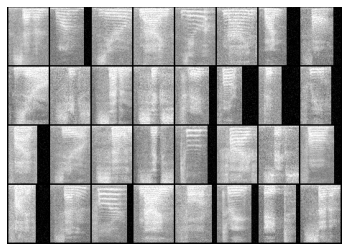

In [202]:
from torchvision.utils import make_grid
import tqdm

## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  classifier = classifier,
                  classes = classes,
                  batch_size = 32,
                  num_steps = 300,
                  input_t = None,
                  z = None,
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

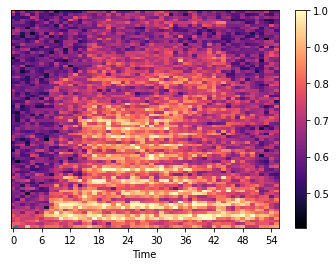

In [210]:
fig, ax = plt.subplots()
img = librosa.display.specshow(samples[5].cpu().squeeze().numpy())
fig.colorbar(img, ax=ax)

a = inference_to_audio(samples[5].to(torch.float32))
ipd.Audio(a, rate= 22050)

In [118]:
samples[-1].shape

torch.Size([1, 80, 56])

In [191]:
classes

tensor([7, 1, 0, 9, 0, 9, 1, 4, 0, 6, 7, 6, 3, 4, 2, 3, 5, 0, 7, 6, 2, 5, 6, 4,
        5, 7, 4, 9, 4, 3, 8, 7], device='cuda:0')

In [ ]:
nosiy_data.dtype